**извлечение признаков из текста на естественном языке**

классификатор текстов SnowballStemmer+TfidfVectorizer

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [1]:
import numpy as np
import numpy.random as rng

from tqdm.notebook import tqdm

import pandas as pd

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 
tqdm.pandas()

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

SKLEARN_VERSION

'1.0.2'

## тексты

In [6]:
# загружаем тексты
data = pd.read_pickle('../data/text/news.pkl.gz')
print('записей:',len(data))
data.sample(2)

записей: 3196


,text,tag
2882,"Источник фото: autoshcool.ru\n\nВ Министерстве транспорта Южной Кореи появилась информация об отзыве 2,4 тысяч автомобилей брендов Audi, Mercedes-Benz и Volvo. Причиной отзывной кампании автопроиз...",auto
670,Клубные карты в фитнес-клуб World Class уже в продаже - скидка 40%\n\n29 ноября 2016 в 9:00\n\n*На правах рекламы\n\nПолноформатный семейный клуб World Class LITE Малиновка откроется в феврале 201...,reclama


## токенизация и очистка

In [8]:
import re

# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

In [9]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

  0%|          | 0/3196 [00:00<?, ?it/s]

##  Vectorizer

In [10]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenizer_stemmer(s,stemmer=stemmer,stopwords=stopwords): 
    for w in s.split(' '):
        o = stemmer.stem(w).replace('^','')
        if len(o)<2: continue
        if o in stopwords: continue
        yield o        

In [11]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

# вариант использования токенайзера вместе с векторайзером
tf = TfidfVectorizer(
        use_idf=False, 
        norm='l2', 
        tokenizer=tokenizer_stemmer, 
        token_pattern=None
    ).fit( data['ctext'] )

CPU times: user 1min 15s, sys: 53.6 ms, total: 1min 15s
Wall time: 1min 16s


In [12]:
vcb1 = sorted(tf.vocabulary_)
print(len(vcb1))
pd.Series(vcb1).sample(30)

36354


16711             люс
22992            пиар
23177        платформ
12649           иголк
8346         гаврилов
11893           замер
34980            чувв
27139       распиарен
10427      договарива
24818             пош
7206           вобраз
7880          выведен
18836       нанимател
16966         ман-сок
1586             junk
10775            драк
15562           кроос
569           classic
34349             хот
4043            аллюз
9179             град
27203         рассеян
7981            вызов
1876        manupubby
24377          попада
29436      следовател
9890            деонт
31363         таракан
8593     генподрядчик
6642          верещат
dtype: object

In [13]:
# pd.Series(vcb1).sample(30)

## формируем датасеты

In [14]:
%%time 

X = tf.transform( data['ctext'])
X.shape

CPU times: user 1min 17s, sys: 33.2 ms, total: 1min 17s
Wall time: 1min 18s


(3196, 36354)

In [15]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [16]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 36354), (2237,), (959, 36354), (959,))

## обучаем классификатор

In [18]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [19]:
# для правильный ответов на учебном наборе
o = clf.predict(X_train)
accuracy_score(y_train,o)

0.9995529727313366

In [20]:
# для правильный ответов на тестовом наборе
o = clf.predict(X_test)
accuracy_score(y_test,o)

0.8686131386861314

In [21]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.96      0.84      0.90        87
           1       0.80      0.93      0.86       101
           2       0.83      0.78      0.80        76
           3       0.85      0.74      0.79        31
           4       0.86      0.93      0.89       123
           5       0.88      0.95      0.91       177
           6       0.80      0.76      0.78        21
           7       0.82      0.53      0.64        17
           8       0.86      1.00      0.93        68
           9       0.71      0.34      0.46        44
          10       0.96      1.00      0.98       118
          11       0.88      0.76      0.82        89
          12       0.64      1.00      0.78         7

    accuracy                           0.87       959
   macro avg       0.83      0.81      0.81       959
weighted avg       0.87      0.87      0.86       959



---

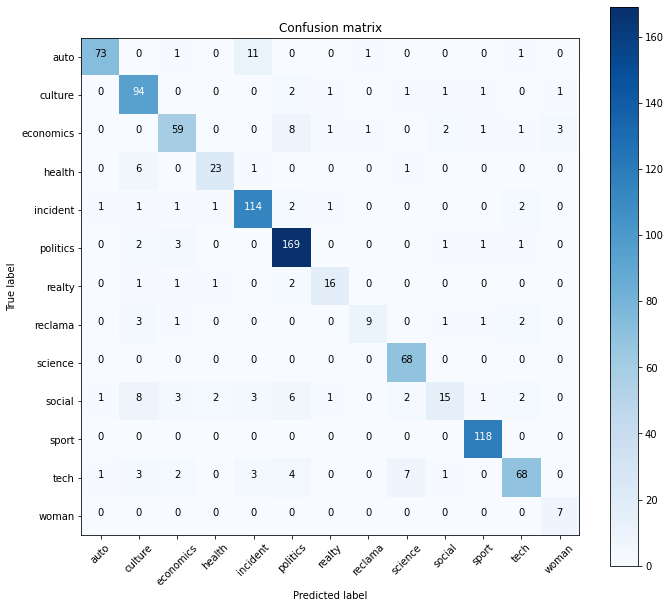

In [22]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [23]:
o = clf.predict(X)

In [24]:
labels_inv = { labels[k]:k for k in labels }
# labels_inv

In [25]:
for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: tech
predict: tech
В таблице Менделеева официально появился Московий 30 ноября 2016 в 14:08 42.TUT.BY 28 ноября в таблице Менделеева официально закреплены четыре новых названия — нихоний, московий, теннессин и оганес...
- - - - - - - - - - - - - - - - - -
tag: tech
predict: tech
На всех столичных вокзалах появились QR-коды для обратной связи 13 декабря. Mossovetinfo.ru — На всех вокзалах Москвы установили специальные брендированные таблички с QR-кодами для обратной связи, со...
- - - - - - - - - - - - - - - - - -
tag: incident
predict: incident
Не менее 14 человек погибли в результате наводнения в Таиланде 6 декабря 2016 в 12:47 Русская служба Би-би-си Фото: Reuters По меньшей мере 14 человек погибли и трое пропали без вести в результате...
- - - - - - - - - - - - - - - - - -
tag: tech
predict: tech
Компания Apple добавит второй слот для SIM-карты в новом iPhone, который представят в конце 2017 года, сообщает Gizmochina. В начале 2016 года Apple подала две патентные заявки, одна и

In [ ]:
# https://habr.com/ru/post/205360/